### Details of the dataset:
##### The dataset contains information about the Datetime, Latitude, Longitude and Base of each uber ride that happened in the month of July 2014 at New York City, USA

Date/Time : The date and time of the Uber pickup<br>
Lat : The latitude of the Uber pickup<br>
Lon : The longitude of the Uber pickup<br>
Base : The TLC base company code affiliated with the Uber pickup<br>

The Base codes are for the following Uber bases:<br>
B02512 : Unter<br>
B02598 : Hinter<br>
B02617 : Weiter<br>
B02682 : Schmecken<br>
B02764 : Danach-NY<br>

In [132]:
# !pip3 -q install numpy pandas matplotlib seaborn geopy folium datetime scipy sklearn tensorflow

In [133]:
#The following libraries are required to run this notebook

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import geopy.distance
from math import radians,cos,sin,asin,sqrt
import folium
import datetime
from folium.plugins import HeatMap
from scipy.stats import ttest_ind

matplotlib.rcParams.update({'font.size': 12})

**Reading the uber dataset**

In [134]:
!ls ../input/uber-pickups-in-new-york-city/uber-raw-data-jul14.csv

ls: cannot access '../input/uber-pickups-in-new-york-city/uber-raw-data-jul14.csv': No such file or directory


In [135]:
uber_data = pd.read_csv('/content/uber-raw-data-jun14.csv')

In [136]:
# Print the first 10 elements
uber_data.head(10)

,Date/Time,Lat,Lon,Base
0,6/1/2014 0:00:00,40.7293,-73.9920,B02512
1,6/1/2014 0:01:00,40.7131,-74.0097,B02512
2,6/1/2014 0:04:00,40.3461,-74.6610,B02512
3,6/1/2014 0:04:00,40.7555,-73.9833,B02512
4,6/1/2014 0:07:00,40.6880,-74.1831,B02512
5,6/1/2014 0:08:00,40.7152,-73.9917,B02512
6,6/1/2014 0:08:00,40.7282,-73.9910,B02512
7,6/1/2014 0:08:00,40.3042,-73.9794,B02512
8,6/1/2014 0:09:00,40.7270,-73.9915,B02512
9,6/1/2014 0:10:00,40.7221,-73.9965,B02512


In [137]:
#print the type of data in Date/Time
type(uber_data.loc[0,'Date/Time'])

str

**The type is str!. Let's  convert it to datetime format for easy indexing**

In [138]:
uber_data['Date/Time'] = pd.to_datetime(uber_data['Date/Time'])

**Let us divide each hour in existing Date/Time column into four smaller bins of 15 mins each:**

**[0mins -15mins], [15mins - 30mins], [30mins - 45mins] and [45mins - 60mins]**

**This will allow us to visualize the time series more precisely.**

In [139]:
#create a new column to store this new binned column
uber_data['BinnedHour']=uber_data['Date/Time'].dt.floor('15min')

In [140]:
#printing the new column - BinnedHour
uber_data['BinnedHour']

,BinnedHour
0,2014-06-01 00:00:00
1,2014-06-01 00:00:00
2,2014-06-01 00:00:00
3,2014-06-01 00:00:00
4,2014-06-01 00:00:00
...,...
663839,2014-06-30 22:30:00
663840,2014-06-30 23:00:00
663841,2014-06-30 23:00:00
663842,2014-06-30 23:15:00


### Visualizing the Dataset

**Let us visualize the total uber rides per day in the month of July 2014**

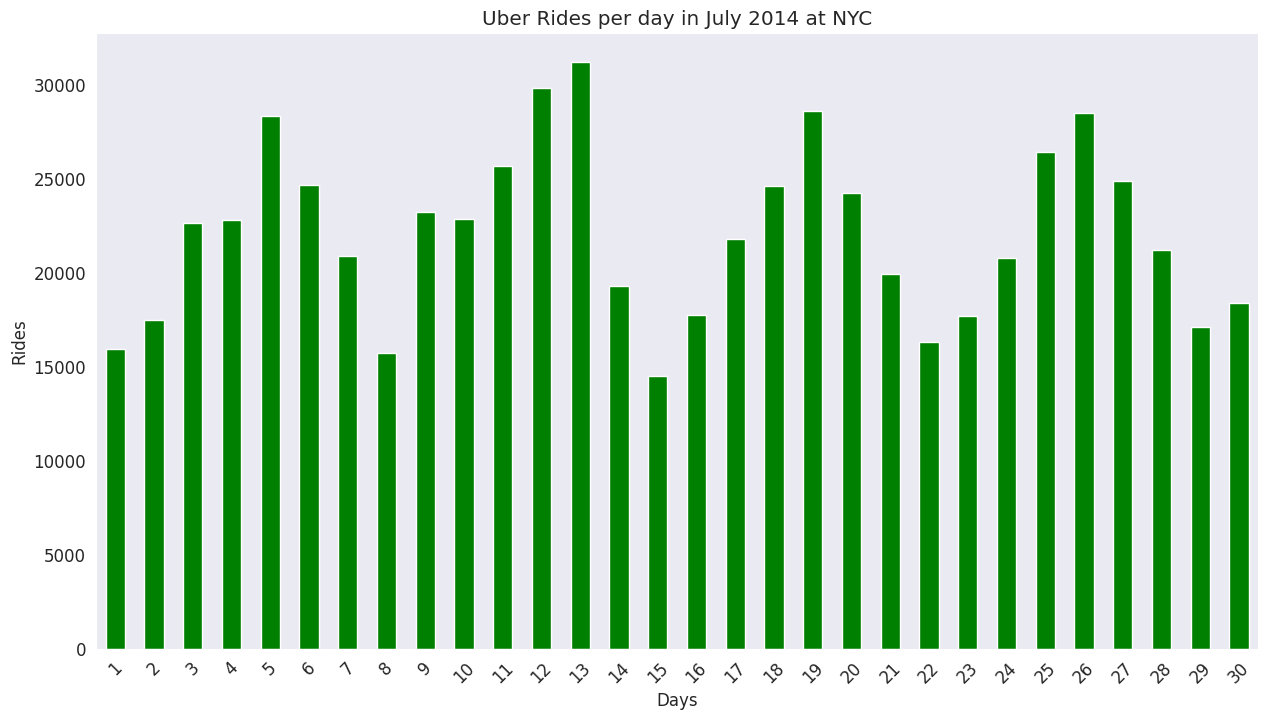

In [141]:
plt.figure(figsize=(15,8))
uber_data['BinnedHour'].dt.day.value_counts().sort_index().plot(kind='bar',color='green')
for item in plt.gca().get_xticklabels():
    item.set_rotation(45)
plt.title('Uber Rides per day in July 2014 at NYC')
plt.xlabel('Days')
_=plt.ylabel('Rides')

**Observe the nearly recurring pattern in the data!. It is very noticable after day 11.**

**Let us have a more closer look at it, say every 15 minutes from July 1 to July 31.**

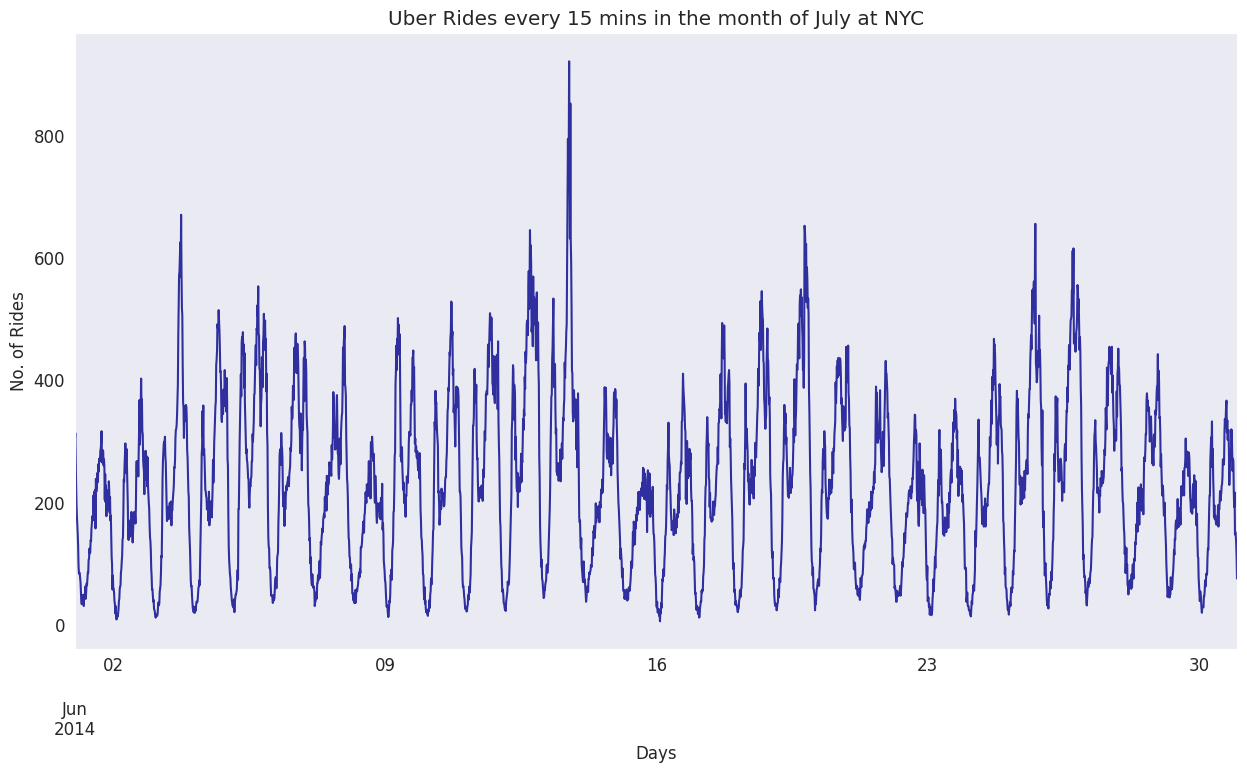

In [142]:
plt.figure(figsize=(15,8))
uber_data['BinnedHour'].value_counts().sort_index().plot(c='darkblue',alpha=0.8)
plt.title('Uber Rides every 15 mins in the month of July at NYC')
plt.xlabel('Days')
_=plt.ylabel('No. of Rides')

**The underlying trend is clearly visible now. It conveys that in a day there are times when the pickups are very low and very high, and they seem to follow a pattern.**

**Q) Which times correspond to the highest and lowest peaks in the plot above?**

In [143]:
uber_data['BinnedHour'].value_counts()

,count
BinnedHour,
2014-06-13 18:00:00,922
2014-06-13 18:45:00,853
2014-06-13 17:15:00,795
2014-06-13 17:45:00,770
2014-06-13 18:15:00,749
...,...
2014-06-03 02:00:00,12
2014-06-17 02:30:00,12
2014-06-02 02:00:00,11


**The highest peak corresponds to the time 19:15(7:15 PM), 15th July 2014 and has a ride count of 915 and the lowest peak corresponds to the time 02:30, 7th July 2014 and has a ride count of 10**

**Now, Lets visualize the week wise trends in the data. For it, we have to map each date into its day name using a dictionary**

In [144]:
#defining a dictionary to map the weekday to day name
DayMap={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
uber_data['Day']=uber_data['BinnedHour'].dt.weekday.map(DayMap)

In [145]:
#Separating the date to another column
uber_data['Date']=uber_data['BinnedHour'].dt.date

In [146]:
#Defining ordered category of week days for easy sorting and visualization
uber_data['Day']=pd.Categorical(uber_data['Day'],categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],ordered=True)

In [147]:
#Separating time from the "BinnedHour" Column
uber_data['Time']=uber_data['BinnedHour'].dt.time

**Rearranging the dataset for weekly analysis**

In [148]:
weekly_data = uber_data.groupby(['Date','Day','Time']).count().dropna().rename(columns={'BinnedHour':'Rides'})['Rides'].reset_index()
weekly_data.head(10)

<ipython-input-148-168e0ec8e1f0>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekly_data = uber_data.groupby(['Date','Day','Time']).count().dropna().rename(columns={'BinnedHour':'Rides'})['Rides'].reset_index()


,Date,Day,Time,Rides
0,2014-06-01,Monday,00:00:00,0
1,2014-06-01,Monday,00:15:00,0
2,2014-06-01,Monday,00:30:00,0
3,2014-06-01,Monday,00:45:00,0
4,2014-06-01,Monday,01:00:00,0
5,2014-06-01,Monday,01:15:00,0
6,2014-06-01,Monday,01:30:00,0
7,2014-06-01,Monday,01:45:00,0
8,2014-06-01,Monday,02:00:00,0
9,2014-06-01,Monday,02:15:00,0


**Grouping weekly_data by days to plot total rides per week in july 2014.**

In [149]:
#Grouping the weekly_data daywise
daywise = weekly_data.groupby('Day')['Rides'].sum() # Sum only the 'Rides' column
daywise

<ipython-input-149-b3d34ef0ff7c>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daywise = weekly_data.groupby('Day')['Rides'].sum() # Sum only the 'Rides' column


,Rides
Day,
Monday,94655
Tuesday,88134
Wednesday,99654
Thursday,115325
Friday,105056
Saturday,81364
Sunday,79656


<ipython-input-150-46b699e8bebf>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x = daywise.index,y= vals,palette=colorPal)
<ipython-input-150-46b699e8bebf>:13: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax=sns.barplot(x = daywise.index,y= vals,palette=colorPal)


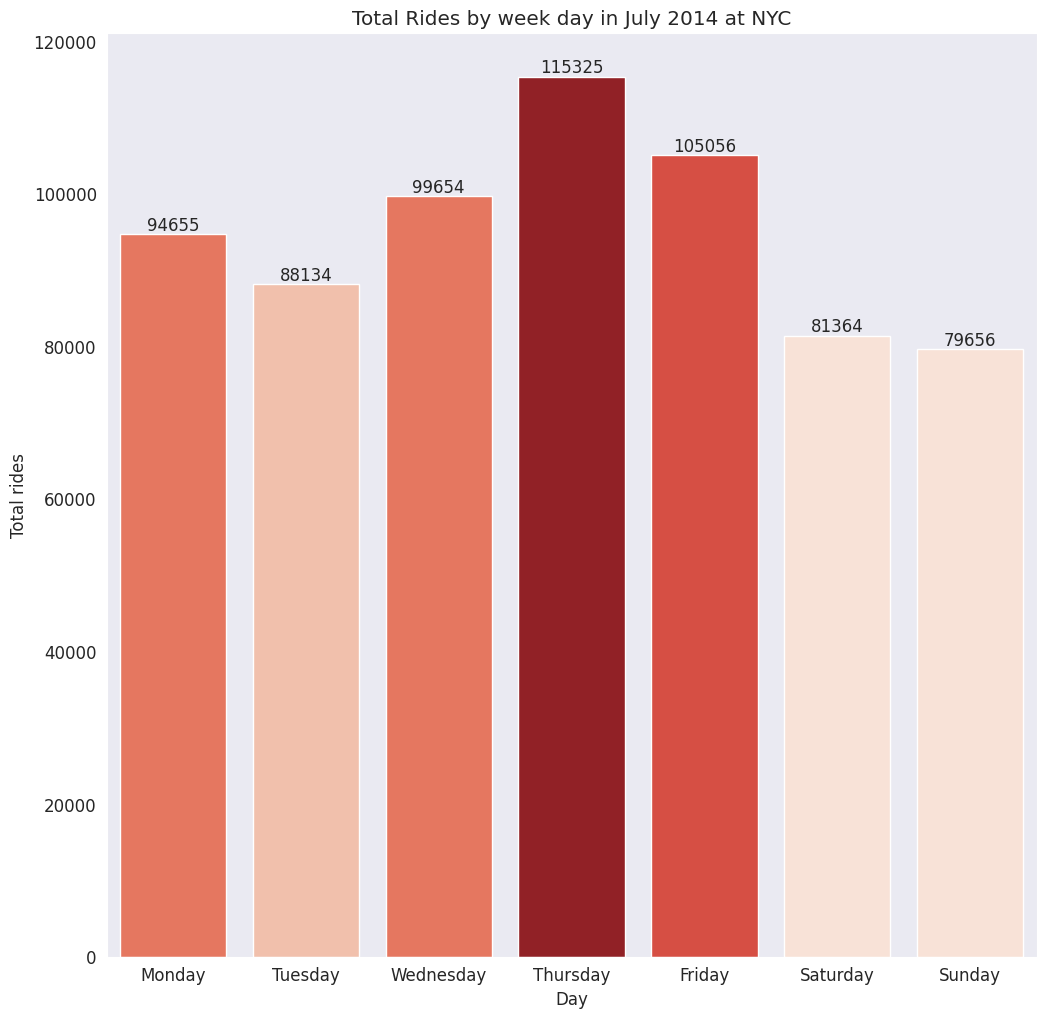

In [150]:
#Plotting the graphs for a better visualization
sns.set_style("dark")
plt.figure(figsize=(12,12))

#Creating a customized color palette for custom hue according to height of bars
vals = daywise.to_numpy().ravel()
normalized = (vals - np.min(vals)) / (np.max(vals) - np.min(vals))
indices = np.round(normalized * (len(vals) - 1)).astype(np.int32)
palette = sns.color_palette('Reds', len(vals))
colorPal = np.array(palette).take(indices, axis=0)

#Creating a bar plot
ax=sns.barplot(x = daywise.index,y= vals,palette=colorPal)
plt.ylabel('Total rides')
plt.title('Total Rides by week day in July 2014 at NYC')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2.0,rect.get_height(),int(rect.get_height()), ha='center', va='bottom')

**According to the bar plot above, rides are maximum on Thursdays and minimum on Sundays. Sundays having the lowest number of rides makes sense logically, as it's a holiday and people often take rest on that day.**

In [151]:
weekly_data = weekly_data.groupby(['Day','Time'])['Rides'].mean() # Calculate the mean of 'Rides' column only
weekly_data.head(10)

<ipython-input-151-f7d2b2cb3d31>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekly_data = weekly_data.groupby(['Day','Time'])['Rides'].mean() # Calculate the mean of 'Rides' column only


Day     Time    
Monday  00:00:00    9.000000
        00:15:00    8.200000
        00:30:00    7.166667
        00:45:00    6.033333
        01:00:00    5.033333
        01:15:00    4.933333
        01:30:00    4.000000
        01:45:00    3.100000
        02:00:00    3.166667
        02:15:00    2.766667
Name: Rides, dtype: float64

In [152]:
#Unstacking the data to create heatmap
weekly_data= weekly_data.unstack(level=0)
weekly_data

Day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Time,,,,,,,
00:00:00,9.000000,6.833333,10.666667,14.833333,19.366667,36.500000,49.100000
00:15:00,8.200000,6.300000,8.100000,11.766667,15.733333,30.700000,43.900000
00:30:00,7.166667,6.466667,7.666667,9.366667,14.166667,26.200000,40.900000
00:45:00,6.033333,4.466667,6.766667,9.466667,11.933333,24.933333,37.266667
01:00:00,5.033333,4.200000,5.000000,8.400000,12.233333,23.733333,33.433333
...,...,...,...,...,...,...,...
22:45:00,22.600000,24.333333,33.866667,54.800000,53.000000,53.866667,25.000000
23:00:00,19.233333,21.966667,32.300000,46.466667,48.800000,54.166667,20.233333
23:15:00,17.366667,17.400000,22.033333,40.300000,48.900000,50.000000,14.733333


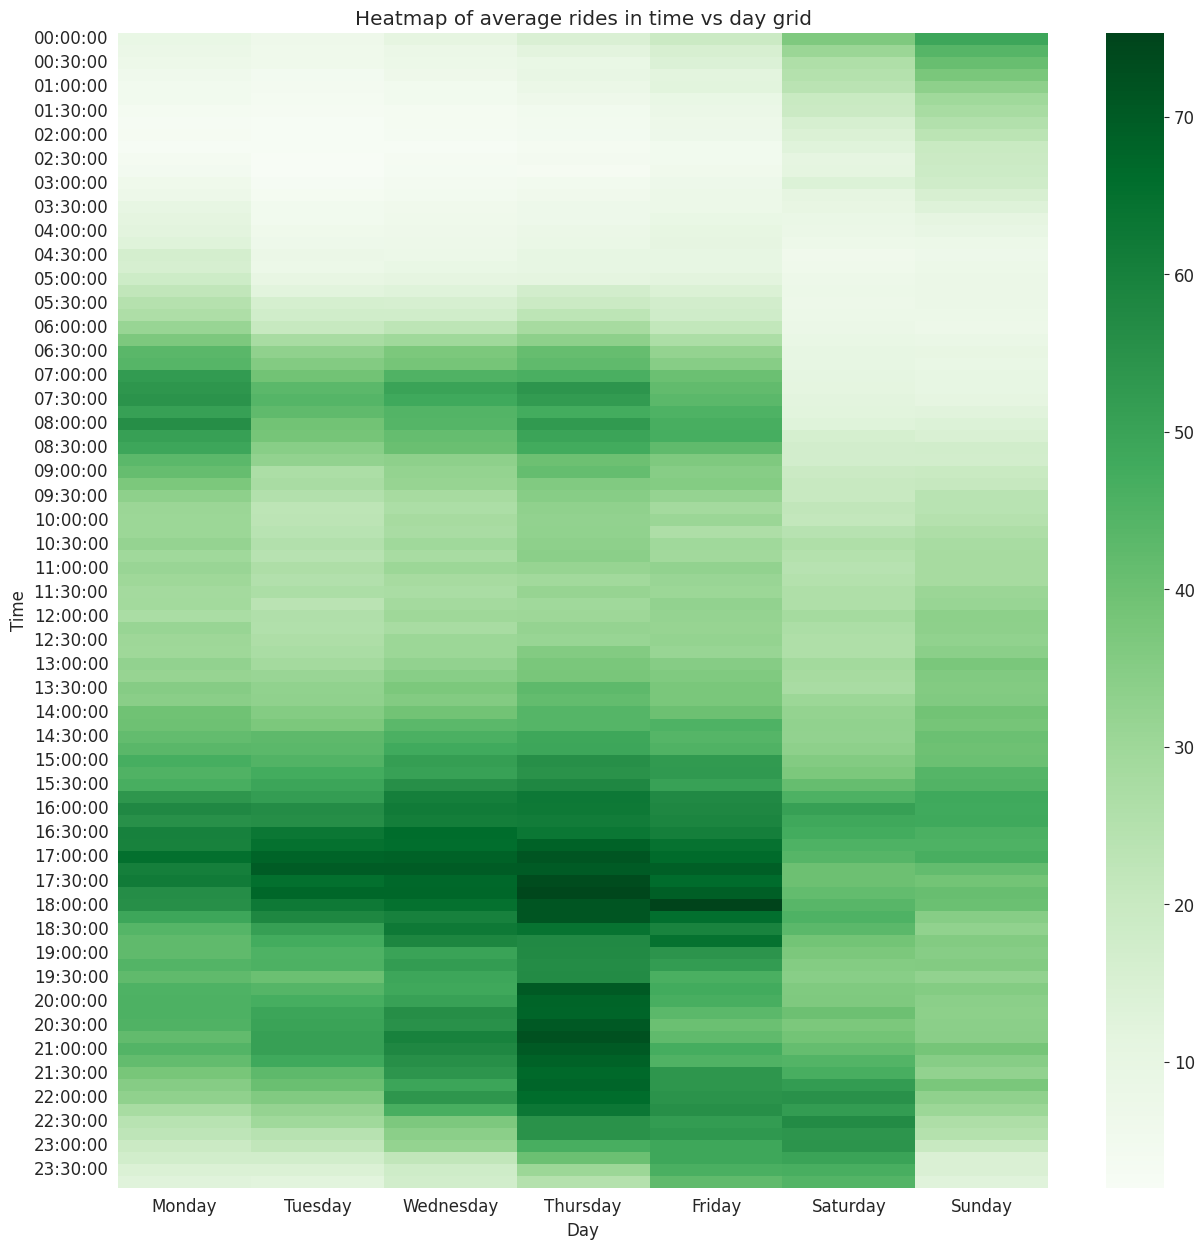

In [153]:
plt.figure(figsize=(15,15))
sns.heatmap(weekly_data,cmap='Greens')
_=plt.title('Heatmap of average rides in time vs day grid')

**The heatmap indicates that the maximum average uber rides occur around 5:30PM to 6:15PM on Wednesdays and Thursdays and their values fall between 550 to 620.**

**Here is another way of looking at it:**

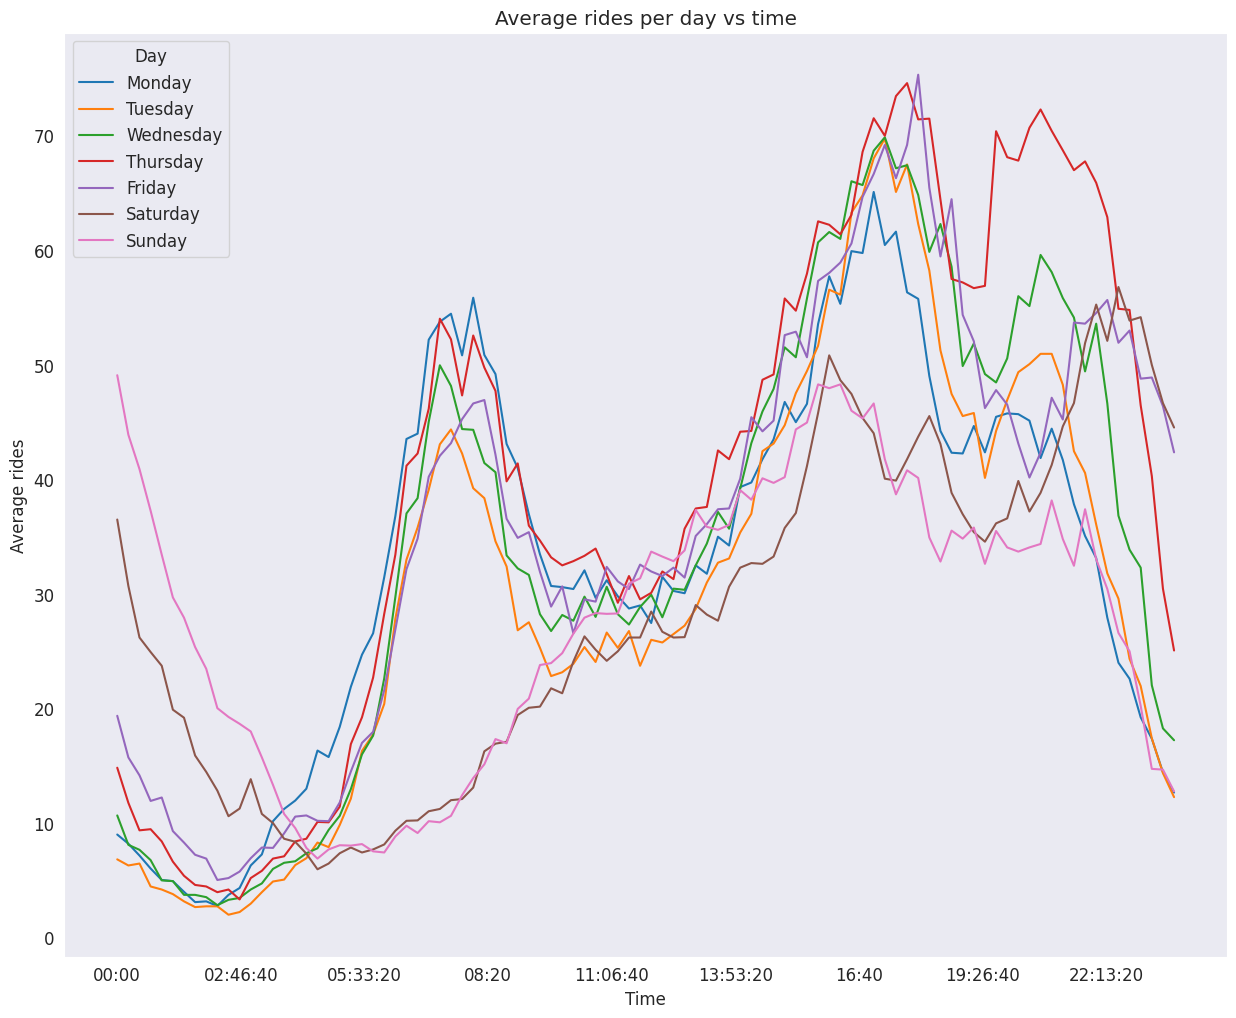

In [154]:
plt.figure(figsize=(15,12))
weekly_data.plot(ax=plt.gca())
_=plt.title('Average rides per day vs time')
_=plt.ylabel('Average rides')
plt.locator_params(axis='x', nbins=10)

**Finding average rides on any day**

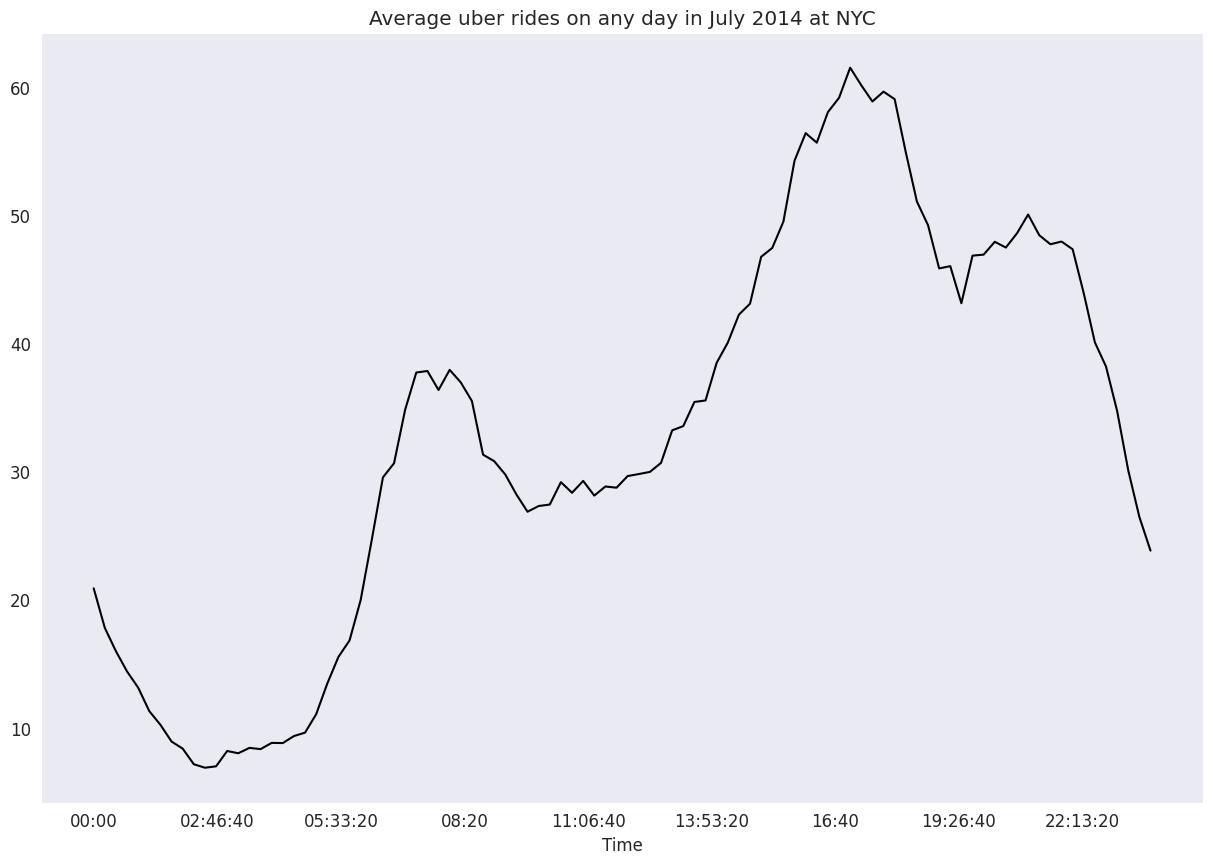

In [155]:
plt.figure(figsize=(15,10))
weekly_data.T.mean().plot(c = 'black')
_=plt.title('Average uber rides on any day in July 2014 at NYC')
plt.locator_params(axis='x', nbins=10)

**This plot further confirms that the average rides on any given day is lowest around 2 AM and highest in the around 5:30 PM.**

**Now, let's try visualizing the relationship between Base and total number of rides in July 2014:**

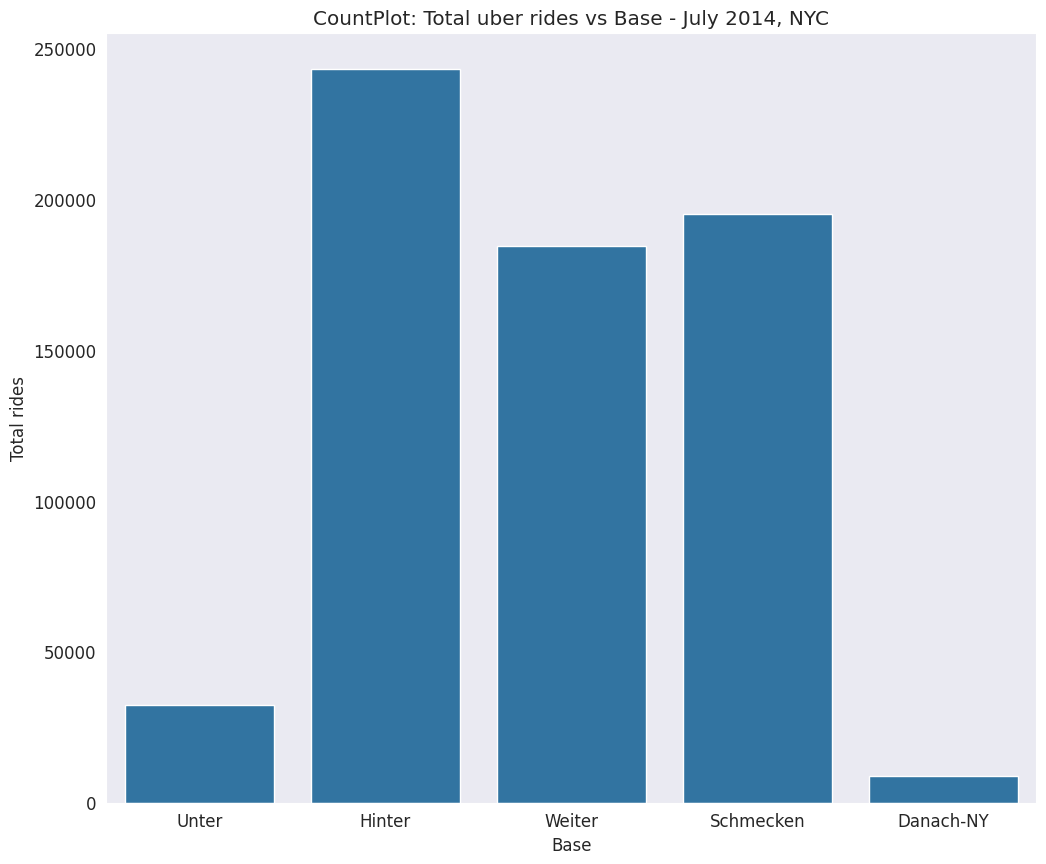

In [156]:
#A mapper to map base number with its name
BaseMapper={'B02512' : 'Unter', 'B02598' : 'Hinter', 'B02617' : 'Weiter', 'B02682' : 'Schmecken','B02764' : 'Danach-NY'}

#Count plot of Base
plt.figure(figsize=(12,10))
sns.set_style("dark")
_=sns.countplot(x=uber_data['Base'].map(BaseMapper))
plt.ylabel('Total rides')
_=plt.title('CountPlot: Total uber rides vs Base - July 2014, NYC')

**The above plot tells us that most uber rides originated from Weiter Base and least from Danach-NY**

**To know more about the distribution of latitudes and longitudes, let's plot their histograms along with KDEs**

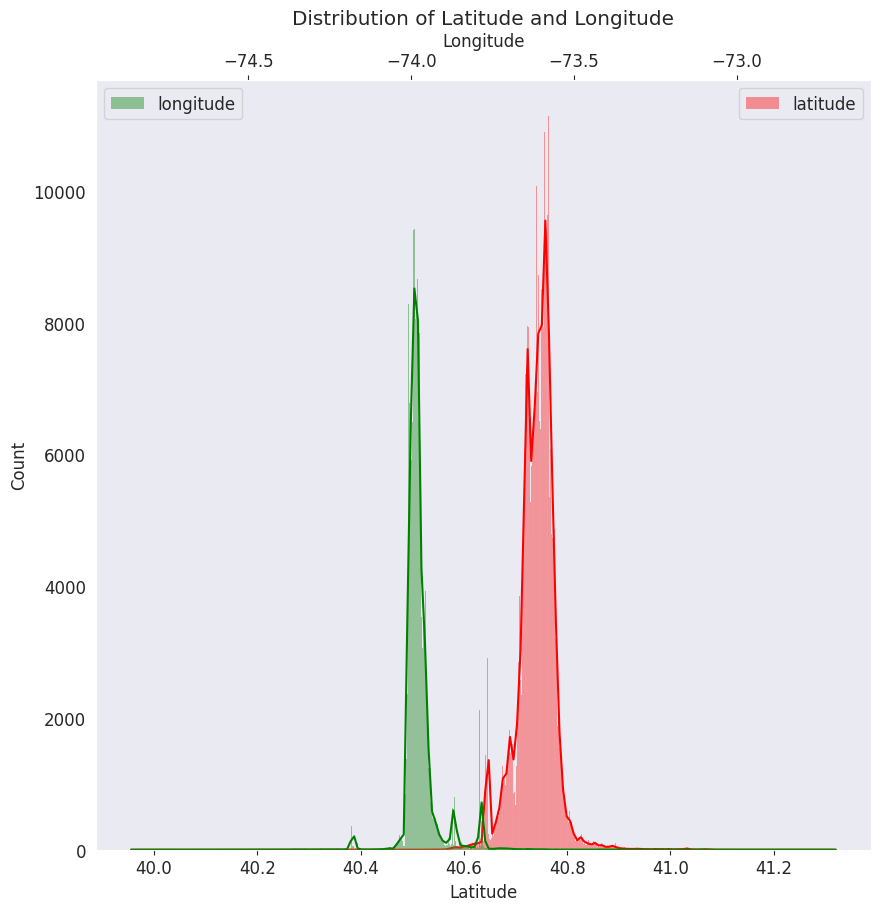

In [157]:
plt.figure(figsize=(10,10))
sns.histplot(uber_data['Lat'], bins='auto',kde=True,color='r',alpha=0.4,label = 'latitude')
plt.legend(loc='upper right')
plt.xlabel('Latitude')
plt.twiny()
sns.histplot(uber_data['Lon'], bins='auto',kde=True,color='g',alpha=0.4,label = 'longitude')
_=plt.legend(loc='upper left')
_=plt.xlabel('Longitude')
_=plt.title('Distribution of Latitude and Longitude')

**Most latitudes are around 40.25, and longitudes around 40.75. This is true as the dataset comprises information only around New York City. This also indicates that most rides happen around (lat,lon) = (40.25,40.75)**

**Let's display the latitude - longitude information in 2D:**

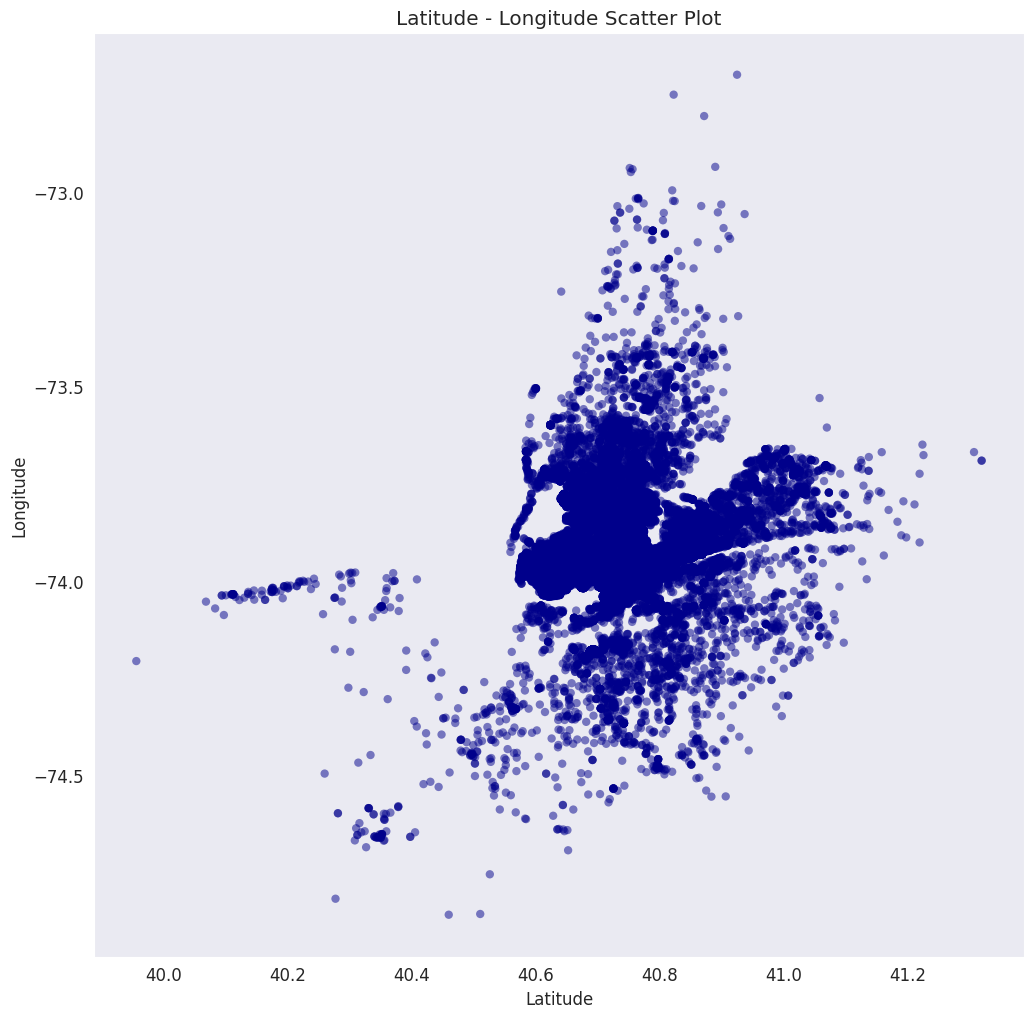

In [158]:
plt.figure(figsize=(12,12))
sns.scatterplot(x='Lat',y='Lon',data=uber_data,edgecolor='None',alpha=0.5,color='darkblue')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
_=plt.title('Latitude - Longitude Scatter Plot')

**The dark blue area in the center shows the regions in New York City that had most number of uber rides in July 2014. The plot is better understood when a geographical map is placed underneath**


**Let's use geopy to calculate the distance between Metropolitan Museum and Emperical State Building**

In [159]:
#This is an example of using geopy
metro_art_coordinates = (40.7794,-73.9632)
empire_state_building_coordinates = (40.7484,-73.9857)

distance = geopy.distance.distance(metro_art_coordinates,empire_state_building_coordinates)

print("Distance = ",distance)

Distance =  3.9319431838520242 km


**Using geopy on a larger dataset may be time consuming on slower PC's. Hence let's use the haversine method**

In [160]:
def haversine(coordinates1,coordinates2):

    lat1=coordinates1[0]
    lon1=coordinates1[1]
    lat2=coordinates2[0]
    lon2=coordinates2[1]

    #convert to radians and apply haverson formula
    lon1,lat1,lon2,lat2 = map(radians,[lon1,lat1,lon2,lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2*asin(sqrt(a))
    r = 3956
    return c*r
print("Distance (mi) = ",haversine(metro_art_coordinates,empire_state_building_coordinates))

Distance (mi) =  2.442501323483997


**Now, Let's try to predict which place they are more closer to, say MM or ESB. This can be done by individually calculating the distance between each uber ride coordinates with MM or ESB coordinates. If they are found to be in a particular threshold radius with MM, then we can predict that the ride is going to MM. Similarly for ESB.**

In [161]:
#calculating distance to MM and ESB for each point in the dataset
uber_data['Distance MM'] = uber_data[['Lat','Lon']].apply(lambda x: haversine(metro_art_coordinates,tuple(x)),axis=1)
uber_data['Distance ESB'] = uber_data[['Lat','Lon']].apply(lambda x: haversine(empire_state_building_coordinates,tuple(x)),axis=1)

In [162]:
#printing the first 10 elements of the updated dataset
uber_data.head(10)

,Date/Time,Lat,Lon,Base,BinnedHour,Day,Date,Time,Distance MM,Distance ESB
0,2014-06-01 00:00:00,40.7293,-73.9920,B02512,2014-06-01,Sunday,2014-06-01,00:00:00,3.772908,1.359325
1,2014-06-01 00:01:00,40.7131,-74.0097,B02512,2014-06-01,Sunday,2014-06-01,00:00:00,5.183800,2.741757
2,2014-06-01 00:04:00,40.3461,-74.6610,B02512,2014-06-01,Sunday,2014-06-01,00:00:00,47.272774,45.020108
3,2014-06-01 00:04:00,40.7555,-73.9833,B02512,2014-06-01,Sunday,2014-06-01,00:00:00,1.956493,0.506038
4,2014-06-01 00:07:00,40.6880,-74.1831,B02512,2014-06-01,Sunday,2014-06-01,00:00:00,13.122094,11.140215
5,2014-06-01 00:08:00,40.7152,-73.9917,B02512,2014-06-01,Sunday,2014-06-01,00:00:00,4.676677,2.313697
6,2014-06-01 00:08:00,40.7282,-73.9910,B02512,2014-06-01,Sunday,2014-06-01,00:00:00,3.822466,1.422008
7,2014-06-01 00:08:00,40.3042,-73.9794,B02512,2014-06-01,Sunday,2014-06-01,00:00:00,32.821299,30.671671
8,2014-06-01 00:09:00,40.7270,-73.9915,B02512,2014-06-01,Sunday,2014-06-01,00:00:00,3.909052,1.508402
9,2014-06-01 00:10:00,40.7221,-73.9965,B02512,2014-06-01,Sunday,2014-06-01,00:00:00,4.322734,1.901767


In [163]:
#Now, let's keep a threshold of 0.25 miles and calculate the number of points that are closer to MM and ESB
#according to these thresholds

print((uber_data[['Distance MM','Distance ESB']]<0.25).sum())

Distance MM      2922
Distance ESB    12991
dtype: int64


**The result above shows the number of rides predicted to MM and ESB**


In [164]:
distance_range = np.arange(0.1,5.1,0.1)

In [165]:
distance_data = [(uber_data[['Distance MM','Distance ESB']] < dist).sum() for dist in distance_range]

In [166]:
distance_data

[Distance MM      545
 Distance ESB    1941
 dtype: int64,
 Distance MM     1904
 Distance ESB    8276
 dtype: int64,
 Distance MM      4860
 Distance ESB    19212
 dtype: int64,
 Distance MM      8962
 Distance ESB    36437
 dtype: int64,
 Distance MM     13790
 Distance ESB    58702
 dtype: int64,
 Distance MM     20378
 Distance ESB    80196
 dtype: int64,
 Distance MM      28317
 Distance ESB    103683
 dtype: int64,
 Distance MM      36833
 Distance ESB    127930
 dtype: int64,
 Distance MM      46870
 Distance ESB    153950
 dtype: int64,
 Distance MM      58331
 Distance ESB    178117
 dtype: int64,
 Distance MM      69338
 Distance ESB    207972
 dtype: int64,
 Distance MM      82130
 Distance ESB    240597
 dtype: int64,
 Distance MM      96330
 Distance ESB    270057
 dtype: int64,
 Distance MM     111759
 Distance ESB    290596
 dtype: int64,
 Distance MM     128176
 Distance ESB    308054
 dtype: int64,
 Distance MM     141579
 Distance ESB    324244
 dtype: int64,
 Distanc

In [167]:
#concatentate and transpose
distance_data = pd.concat(distance_data,axis=1)
distance_data = distance_data.T

In [168]:
#Shifting index
distance_data.index = distance_range

In [169]:
distance_data=distance_data.rename(columns={'Distance MM':'CloserToMM','Distance ESB':'CloserToESB'})

Text(0, 0.5, 'Rides')

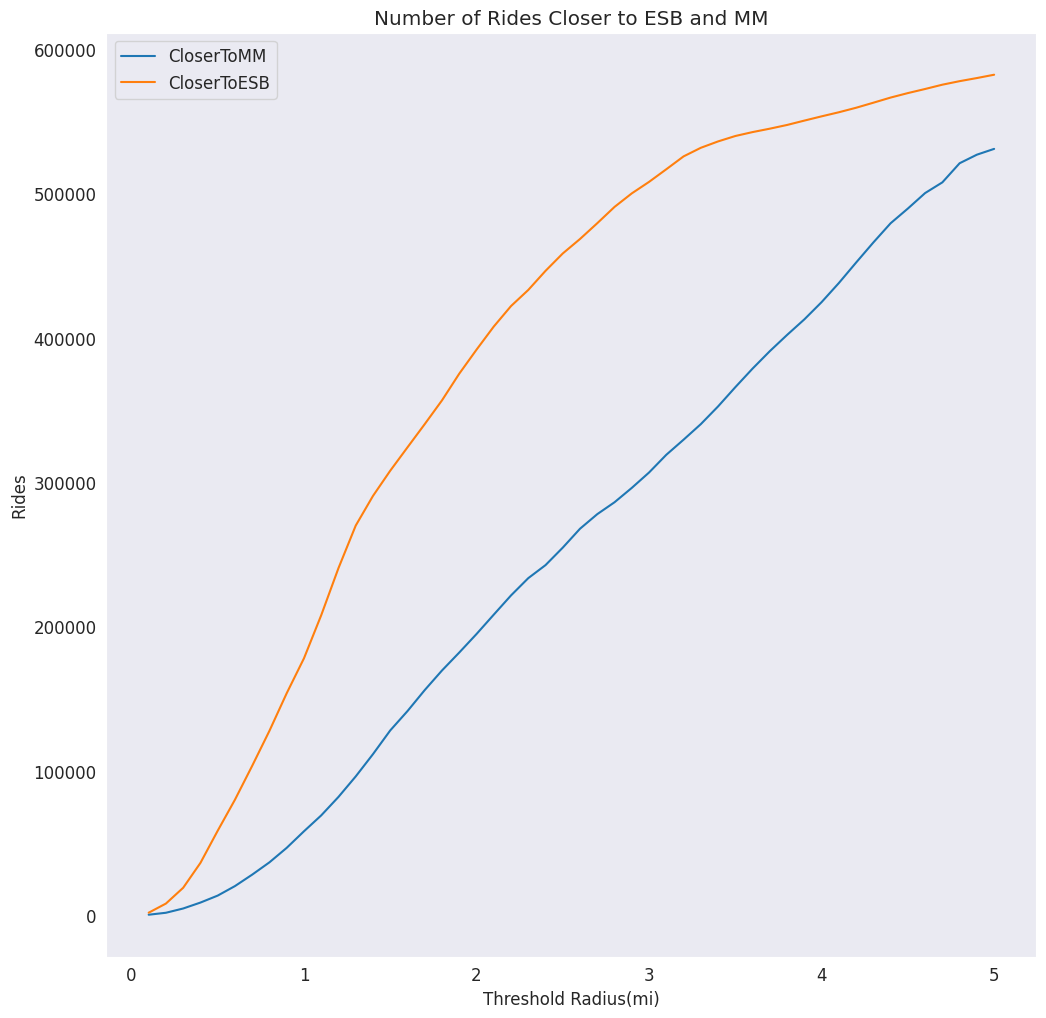

In [170]:
plt.figure(figsize=(12,12))
distance_data.plot(ax=plt.gca())
plt.title('Number of Rides Closer to ESB and MM')
plt.xlabel('Threshold Radius(mi)')
plt.ylabel('Rides')

**The number of riders to MM and ESB initially diverges, but comes closer as threshold increases. Hence as radius increases, the rate of people going towards MM gets higher than that to ESB. In another way of thinking, as we expand the radius, most of the newly discovered rides are going to MM.**

**Now let us observe the heatmap plotted on geographical map (using folium)**

In [171]:
#initilize the map around NYC and set the zoom level to 10
uber_map = folium.Map(location=metro_art_coordinates,zoom_start=10)

#lets mark MM and ESB on the map
folium.Marker(metro_art_coordinates,popup = "MM").add_to(uber_map)
folium.Marker(empire_state_building_coordinates,popup = "ESB").add_to(uber_map)

#convert to numpy array and plot it
Lat_Lon = uber_data[['Lat','Lon']].to_numpy()
folium.plugins.HeatMap(Lat_Lon,radius=10).add_to(uber_map)

#Displaying the map
uber_map

Output hidden; open in https://colab.research.google.com to view.

**Lets reduce the "Influence" of each point on the heatmap by using a weight of 0.5 (by default it is 1)**

In [172]:
uber_data['Weight']=0.5

#Take on 10000 points to plot (Just to speed up things)
Lat_Lon = uber_data[['Lat','Lon','Weight']].to_numpy()

#Plotting
uber_map = folium.Map(metro_art_coordinates,zoom_start=10)
folium.plugins.HeatMap(Lat_Lon,radius=15).add_to(uber_map)
uber_map

Output hidden; open in https://colab.research.google.com to view.

**The plot looks easy to visualize now. Boundaries and intensity distribution is clear**


**Let's now create a HeatMap that changes with time. This will help us to visualize the number of uber rides geographically at a given time.**

**We are plotting only the points that are in a radius of 0.25 miles from MM or ESB**

In [173]:
i = uber_data[['Distance MM','Distance ESB']] < 0.25

i.head(10)

,Distance MM,Distance ESB
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
5,False,False
6,False,False
7,False,False
8,False,False
9,False,False


In [174]:
#Create a boolean mask to choose the rides that satisfy the 0.25 radius threshold
i=i.any(axis=1)

i[i==True]

,0
76,True
108,True
188,True
317,True
353,True
...,...
663502,True
663517,True
663603,True
663641,True


In [175]:
#Create a copy of the data
map_data = uber_data[i].copy()

#use a smaller weight
map_data['Weight'] = 0.1

#Restricting data to that before 8th july for faster calculations
map_data = uber_data[uber_data["BinnedHour"] < datetime.datetime(2014,7,8)].copy()

#Generate samples for each timestamp in "BinnedHour" (these are the points that are plotted for each timestamp)
map_data = map_data.groupby("BinnedHour").apply(lambda x: x[['Lat','Lon','Weight']].sample(int(len(x)/3)).to_numpy().tolist())

<ipython-input-175-3cd123c8215c>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_data = map_data.groupby("BinnedHour").apply(lambda x: x[['Lat','Lon','Weight']].sample(int(len(x)/3)).to_numpy().tolist())


In [176]:
map_data

,0
BinnedHour,
2014-06-01 00:00:00,"[[40.7341, -74.0084, 0.5], [40.7219, -73.9934,..."
2014-06-01 00:15:00,"[[40.7219, -73.9945, 0.5], [40.6829, -73.9598,..."
2014-06-01 00:30:00,"[[40.7204, -73.9872, 0.5], [40.7572, -73.9676,..."
2014-06-01 00:45:00,"[[40.7139, -73.9575, 0.5], [40.7517, -73.9868,..."
2014-06-01 01:00:00,"[[40.7125, -73.9562, 0.5], [40.7274, -73.9855,..."
...,...
2014-06-30 22:45:00,"[[40.7527, -73.9656, 0.5], [40.7589, -73.9923,..."
2014-06-30 23:00:00,"[[40.7223, -73.9943, 0.5], [40.7722, -73.9524,..."
2014-06-30 23:15:00,"[[40.7633, -73.9793, 0.5], [40.7438, -73.9896,..."


In [177]:
#The index to be passed on to heatmapwithtime needs to be a time series of the following format
data_hour_index = [x.strftime("%m%d%Y, %H:%M:%S") for x in map_data.index]

#convert to list to feed it to heatmapwithtime
date_hour_data = map_data.tolist()

#initialize map
uber_map = folium.Map(location=metro_art_coordinates,zoom_start=10)

In [178]:
#plotting
hm = folium.plugins.HeatMapWithTime(date_hour_data,index=date_hour_data)

#add heatmap to folium map(uber_map)
hm.add_to(uber_map)
uber_map

Output hidden; open in https://colab.research.google.com to view.

**Click the play button to visualize the timeseries**

In [179]:
uber_data

,Date/Time,Lat,Lon,Base,BinnedHour,Day,Date,Time,Distance MM,Distance ESB,Weight
0,2014-06-01 00:00:00,40.7293,-73.9920,B02512,2014-06-01 00:00:00,Sunday,2014-06-01,00:00:00,3.772908,1.359325,0.5
1,2014-06-01 00:01:00,40.7131,-74.0097,B02512,2014-06-01 00:00:00,Sunday,2014-06-01,00:00:00,5.183800,2.741757,0.5
2,2014-06-01 00:04:00,40.3461,-74.6610,B02512,2014-06-01 00:00:00,Sunday,2014-06-01,00:00:00,47.272774,45.020108,0.5
3,2014-06-01 00:04:00,40.7555,-73.9833,B02512,2014-06-01 00:00:00,Sunday,2014-06-01,00:00:00,1.956493,0.506038,0.5
4,2014-06-01 00:07:00,40.6880,-74.1831,B02512,2014-06-01 00:00:00,Sunday,2014-06-01,00:00:00,13.122094,11.140215,0.5
...,...,...,...,...,...,...,...,...,...,...,...
663839,2014-06-30 22:40:00,40.7332,-73.9872,B02764,2014-06-30 22:30:00,Monday,2014-06-30,22:30:00,3.427973,1.052417,0.5
663840,2014-06-30 23:12:00,40.7905,-73.9796,B02764,2014-06-30 23:00:00,Monday,2014-06-30,23:00:00,1.149982,2.924253,0.5
663841,2014-06-30 23:13:00,40.7640,-73.9887,B02764,2014-06-30 23:00:00,Monday,2014-06-30,23:00:00,1.705428,1.088474,0.5
663842,2014-06-30 23:15:00,40.7262,-73.9944,B02764,2014-06-30 23:15:00,Monday,2014-06-30,23:15:00,4.019390,1.598953,0.5


In [180]:
weekends = weekly_data[['Saturday','Sunday']]

In [181]:
weekdays = weekly_data.drop(['Saturday','Sunday'],axis=1)

In [182]:
weekends = weekends.mean(axis=1)
weekdays = weekdays.mean(axis=1)

In [183]:
weekdays_weekends = pd.concat([weekdays,weekends],axis=1)
weekdays_weekends.columns = ['Weekdays','Weekends']

In [184]:
weekdays_weekends

,Weekdays,Weekends
Time,,
00:00:00,12.140000,42.800000
00:15:00,10.020000,37.300000
00:30:00,8.966667,33.550000
00:45:00,7.733333,31.100000
01:00:00,6.973333,28.583333
...,...,...
22:45:00,37.720000,39.433333
23:00:00,33.753333,37.200000
23:15:00,29.200000,32.366667


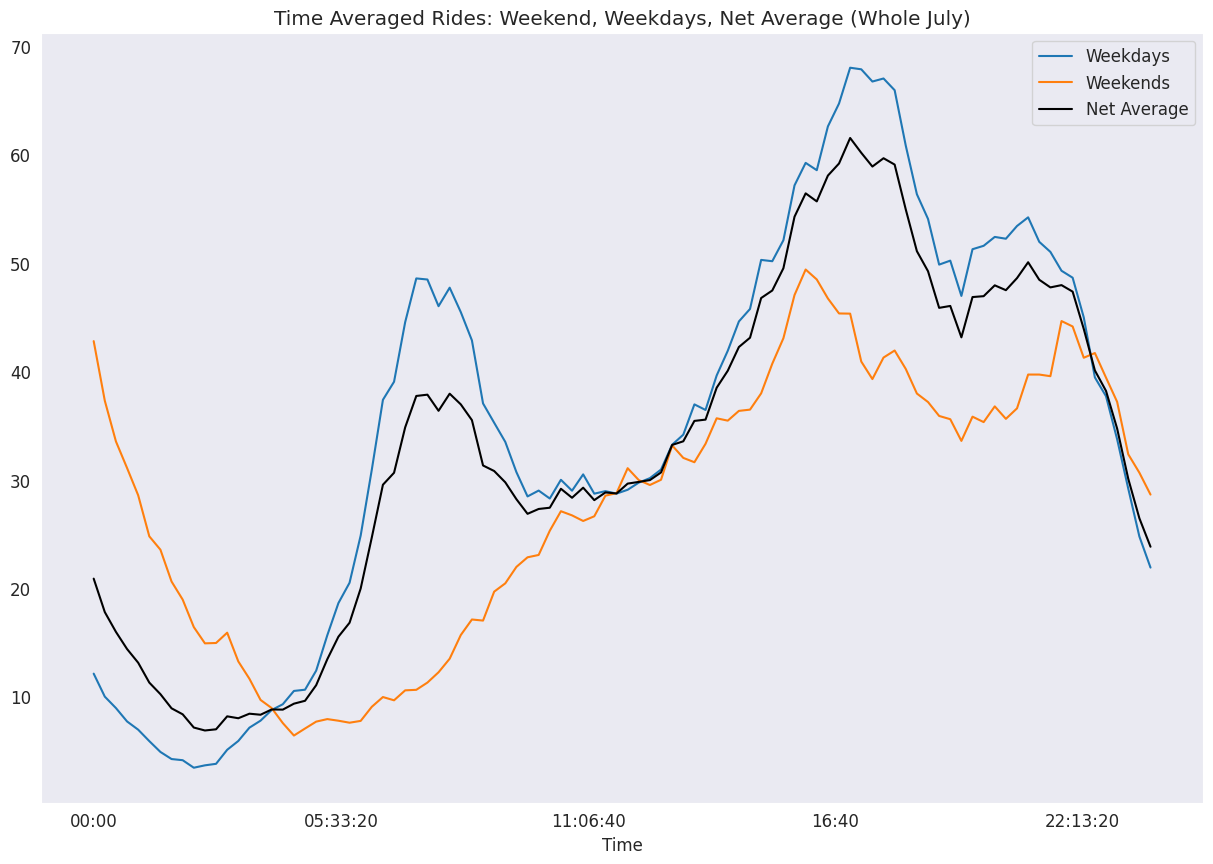

In [185]:
plt.figure(figsize=(15,10))
weekdays_weekends.plot(ax=plt.gca())
weekly_data.T.mean().plot(ax=plt.gca(),c = 'black',label='Net Average')
_=plt.title('Time Averaged Rides: Weekend, Weekdays, Net Average (Whole July)')
_=plt.legend()

**The Net average plot is more similar to the weekdays average because there are more weekdays than weekends.**

**In early morning, weekends have more rides. This makes sense as people often go out at night during the weekends.**

**The number of rides around 8 AM is less on weekends, but more on weekdays as it is usually the time when people goto work. Also, in the weekends, there is a surge in the number of evening rides as people return from work.**

**Let us normalize the weekday and weekends data with their own respective sums. This will give us an insight into the proportional data and help us answer questions like - "What percentage of rides happened around 12AM on weekends or weekdays"?**

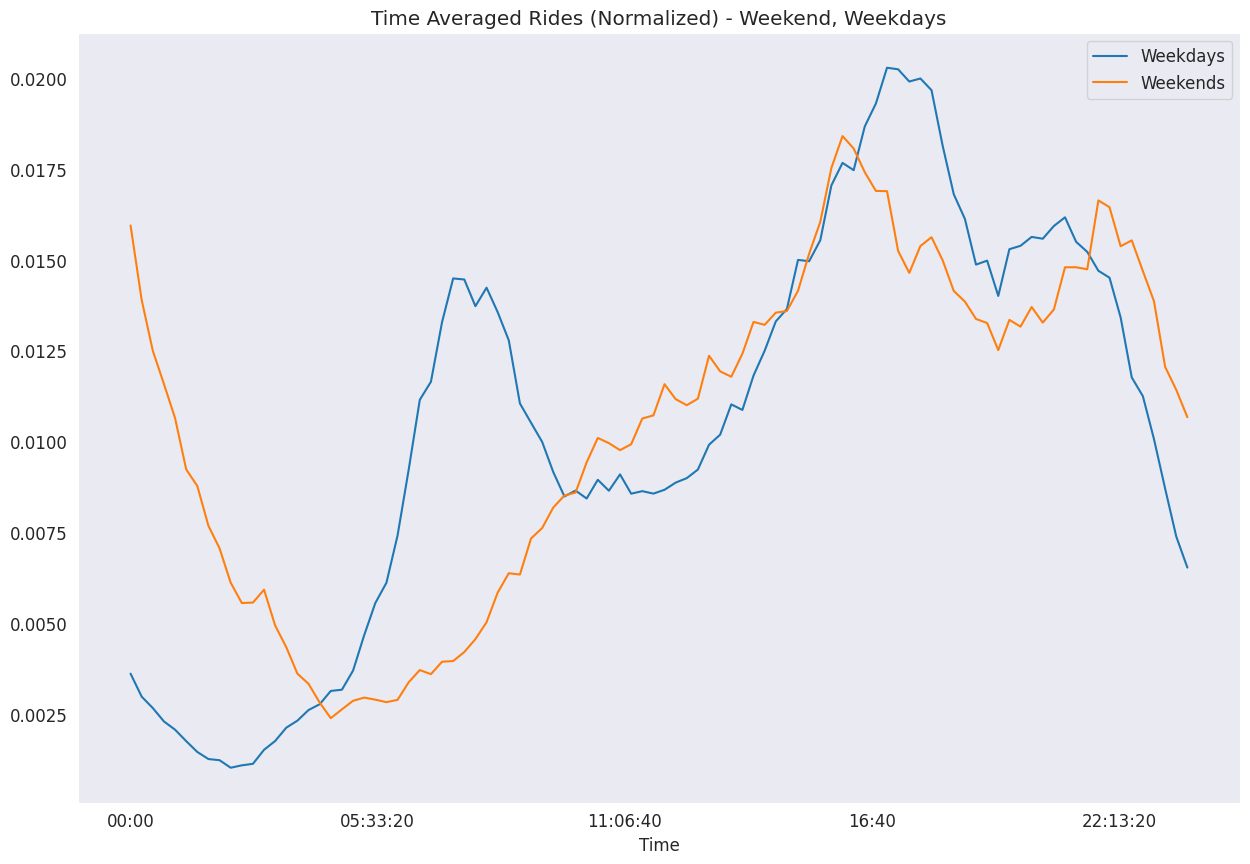

In [186]:
plt.figure(figsize=(15,10))
(weekdays_weekends/weekdays_weekends.sum()).plot(ax=plt.gca())
_=plt.title('Time Averaged Rides (Normalized) - Weekend, Weekdays')

**Nearly 1.5% of the total rides on weekends happen at midnight but only 0.5% of the total rides happen on weekdays!**
**Also, nearly 2% of the total rides on weekdays happen around 5:30PM!**

**So far, we have made our observations by eye. Let us do a statistical T test to compare the time-averaged rides on weekdays and weekends**


In [187]:
#Grouping by date and time and creating a dataset that gives the total rides every 15 mins
for_ttest = uber_data.groupby(['Date','Time']).count()['Day'].reset_index(level=1)

In [188]:
#Total rides on each day in july
uber_data.groupby(['Date']).count()['Day']

,Day
Date,
2014-06-01,15967
2014-06-02,17503
2014-06-03,22674
2014-06-04,22831
2014-06-05,28371
2014-06-06,24683
2014-06-07,20889
2014-06-08,15749
2014-06-09,23244


In [189]:
#Normalizing the dataset by dividing rides in each time slot on a day by total number of rides on that day
for_ttest = pd.concat([for_ttest['Day']/uber_data.groupby(['Date']).count()['Day'],for_ttest['Time']],axis=1)


In [190]:

#renaming
for_ttest=for_ttest.rename(columns={'Day':'NormalizedRides'})

In [191]:
for_ttest

,NormalizedRides,Time
Date,,
2014-06-01,0.018851,00:00:00
2014-06-01,0.019666,00:15:00
2014-06-01,0.016785,00:30:00
2014-06-01,0.014342,00:45:00
2014-06-01,0.012338,01:00:00
...,...,...
2014-06-30,0.007937,22:45:00
2014-06-30,0.007230,23:00:00
2014-06-30,0.006034,23:15:00


In [192]:
for_ttest = pd.concat([for_ttest,pd.to_datetime(for_ttest.reset_index()['Date']).dt.day_name().to_frame().set_index(for_ttest.index).rename(columns={'Date':'Day'})],axis=1)

In [193]:
#uber_data.groupby(['Date','Time','Day']).count().dropna().reset_index()[['Date','Day']].set_index('Date')

In [194]:

for_ttest

,NormalizedRides,Time,Day
Date,,,
2014-06-01,0.018851,00:00:00,Sunday
2014-06-01,0.019666,00:15:00,Sunday
2014-06-01,0.016785,00:30:00,Sunday
2014-06-01,0.014342,00:45:00,Sunday
2014-06-01,0.012338,01:00:00,Sunday
...,...,...,...
2014-06-30,0.007937,22:45:00,Monday
2014-06-30,0.007230,23:00:00,Monday
2014-06-30,0.006034,23:15:00,Monday


**The rides are first normalized by dividing the number of rides in each time slot by the total number of rides on that day**

**Then they are grouped by time and split to weekend and weekdays data and a T test is applied on them.**

**A Null hypothesis is assumed: The average ride counts are similar for each time slot on weekends and weekdays**

In [195]:
ttestvals = for_ttest.groupby('Time').apply(lambda x: ttest_ind(x[x['Day']<'Saturday']['NormalizedRides'],x[x['Day']>='Saturday']['NormalizedRides']))

<ipython-input-195-91aa4120c8d2>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ttestvals = for_ttest.groupby('Time').apply(lambda x: ttest_ind(x[x['Day']<'Saturday']['NormalizedRides'],x[x['Day']>='Saturday']['NormalizedRides']))


In [196]:
ttestvals=pd.DataFrame(ttestvals.to_list(),index = ttestvals.index)

In [197]:
ttestvals

,statistic,pvalue
Time,,
00:00:00,-2.000804,0.055194
00:15:00,-1.935972,0.063026
00:30:00,-1.943523,0.062066
00:45:00,-2.033045,0.051627
01:00:00,-1.917736,0.065397
...,...,...
22:45:00,-0.756961,0.455396
23:00:00,-0.705955,0.486049
23:15:00,0.094258,0.925576


**The t-statistic value is -11.5 around midnight! This means that the assumption(hypothesis) does not hold at that time. The pvalue is very low, hence the null hypthesis is rejected around midnight**

**Let's plot and see the values for all timeslots**

**if we hold a p-value threshold of 5% (confidence level = 95%), corresponding t-statistic value is 1.96**

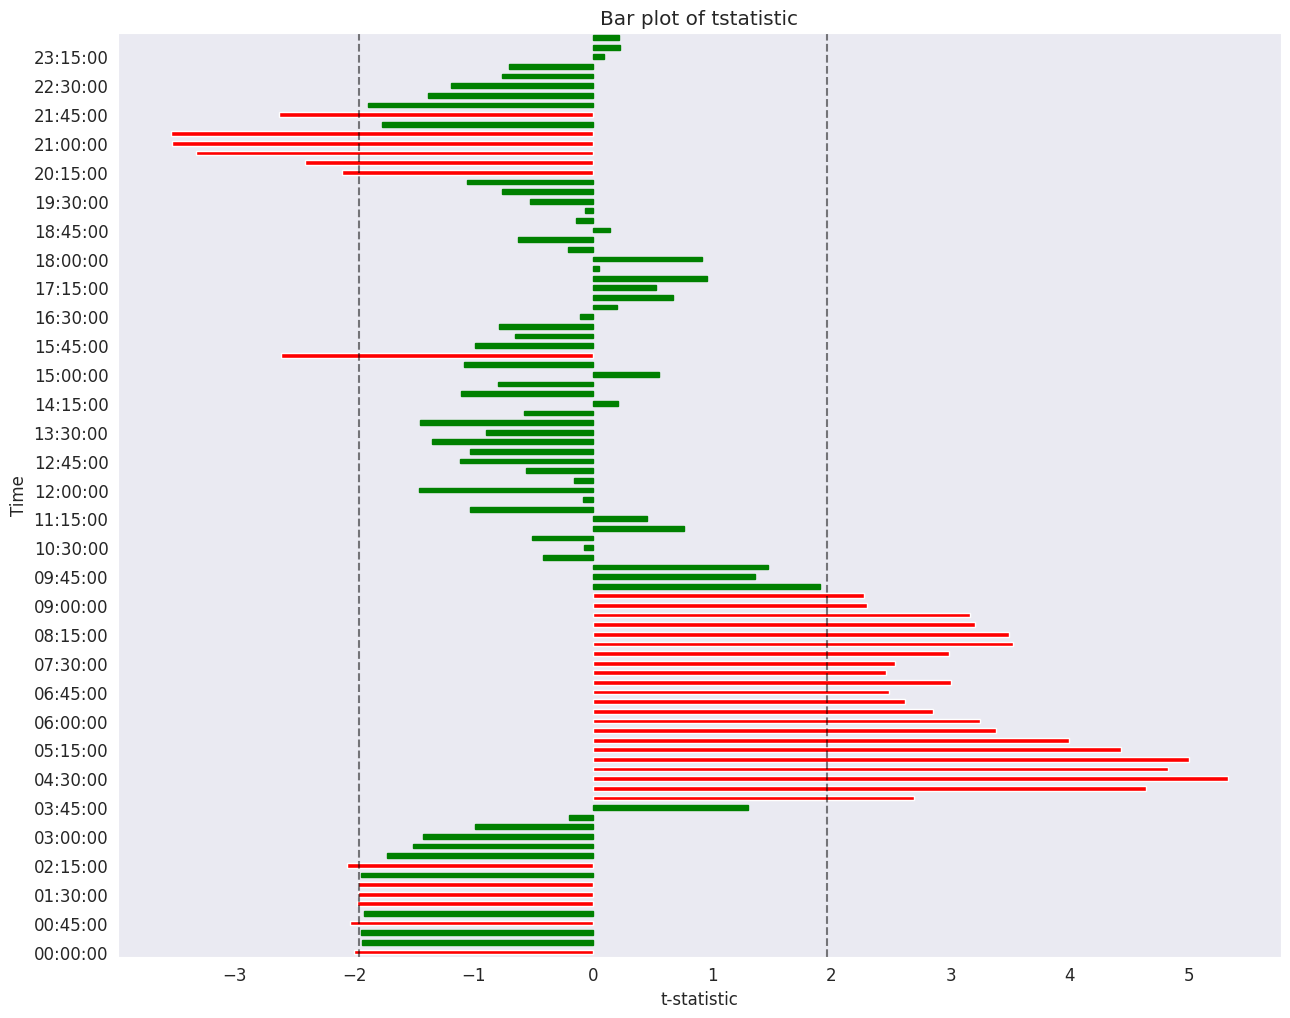

In [198]:
#Let's plot the "statistic" column
plt.figure(figsize=(15,12))
ax=ttestvals['statistic'].plot(kind='barh',color='red',ax=plt.gca())
plt.locator_params(axis='y', nbins=40)
plt.locator_params(axis='x', nbins=10)
plt.xlabel('t-statistic')
plt.axvline(x=1.96,alpha=0.5,color='black',linestyle='--')
plt.axvline(x=-1.96,alpha=0.5,color='black',linestyle='--')

for rect in ax.patches:
    if(abs(rect.get_width())<1.96):
        rect.set_color('green')
_=plt.title('Bar plot of tstatistic')

**The time-average ride counts are assumed similar on weekdays and weekends if the width of the bar plot is less than 1.96. Such values are colored in green.**

**Note that their count is very low**

**Let's visualize a KDE plot of the pvalue to confirm this:**

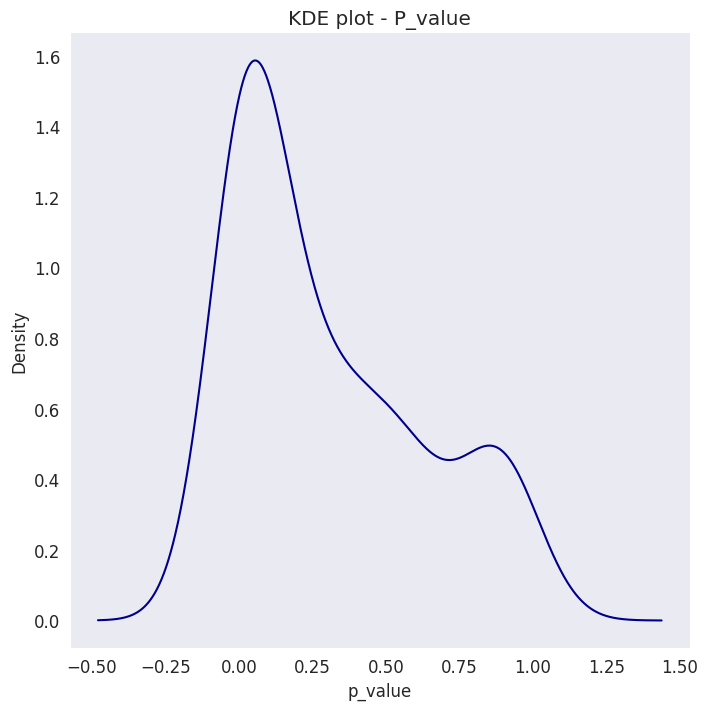

In [199]:
#KDE plot
plt.figure(figsize=(8,8))
ttestvals['pvalue'].plot(kind='kde',color='darkblue',ax=plt.gca())
plt.title('KDE plot - P_value')
_=plt.xlabel('p_value')

**Density peaks around p_value=0. Hence it confirms that the time-averaged rides vary greatly at most time slots on weekends and weekdays**

**P-value distribution:**

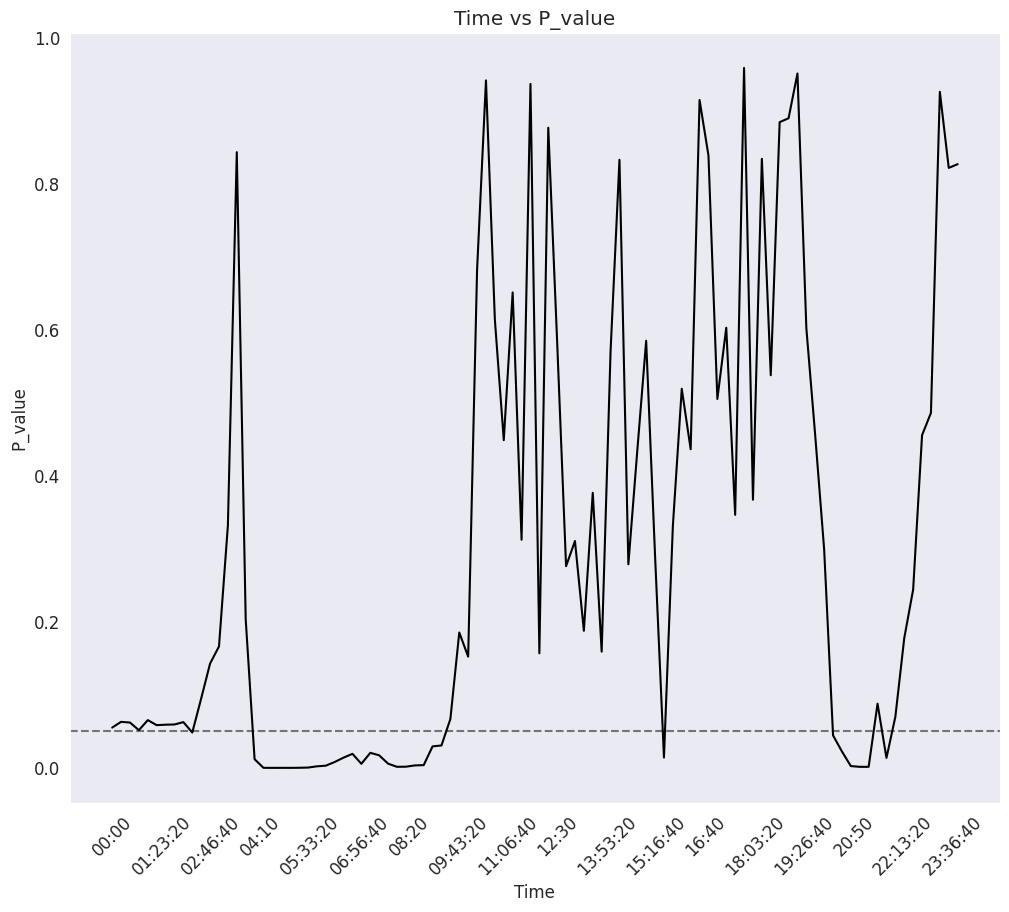

In [200]:
plt.figure(figsize=(12,10))
ax=ttestvals['pvalue'].plot(kind='line',color='black',ax=plt.gca())
plt.axhline(y=0.05,alpha=0.5,color='black',linestyle='--')
plt.locator_params(axis='x',nbins=20)
for item in plt.gca().get_xticklabels():
    item.set_rotation(45)

_=plt.title('Time vs P_value')
_=plt.ylabel('P_value')

**The threshold is p = 0.05. The null hypothesis is accepted at p_values below 0.05**

## Checking Relations in Data

In [201]:
uber_data

,Date/Time,Lat,Lon,Base,BinnedHour,Day,Date,Time,Distance MM,Distance ESB,Weight
0,2014-06-01 00:00:00,40.7293,-73.9920,B02512,2014-06-01 00:00:00,Sunday,2014-06-01,00:00:00,3.772908,1.359325,0.5
1,2014-06-01 00:01:00,40.7131,-74.0097,B02512,2014-06-01 00:00:00,Sunday,2014-06-01,00:00:00,5.183800,2.741757,0.5
2,2014-06-01 00:04:00,40.3461,-74.6610,B02512,2014-06-01 00:00:00,Sunday,2014-06-01,00:00:00,47.272774,45.020108,0.5
3,2014-06-01 00:04:00,40.7555,-73.9833,B02512,2014-06-01 00:00:00,Sunday,2014-06-01,00:00:00,1.956493,0.506038,0.5
4,2014-06-01 00:07:00,40.6880,-74.1831,B02512,2014-06-01 00:00:00,Sunday,2014-06-01,00:00:00,13.122094,11.140215,0.5
...,...,...,...,...,...,...,...,...,...,...,...
663839,2014-06-30 22:40:00,40.7332,-73.9872,B02764,2014-06-30 22:30:00,Monday,2014-06-30,22:30:00,3.427973,1.052417,0.5
663840,2014-06-30 23:12:00,40.7905,-73.9796,B02764,2014-06-30 23:00:00,Monday,2014-06-30,23:00:00,1.149982,2.924253,0.5
663841,2014-06-30 23:13:00,40.7640,-73.9887,B02764,2014-06-30 23:00:00,Monday,2014-06-30,23:00:00,1.705428,1.088474,0.5
663842,2014-06-30 23:15:00,40.7262,-73.9944,B02764,2014-06-30 23:15:00,Monday,2014-06-30,23:15:00,4.019390,1.598953,0.5


In [202]:
#create a copy
df = uber_data.copy()

In [203]:
#get numbers of each weekday
df['WeekDay']=df['Date/Time'].dt.weekday

In [204]:
#Convert datetime to float. egs: 1:15AM will be 1.25, 12:45 will be 12.75 etc
def func(x):
    hr = float(x.hour)
    minute = int(x.minute/15)
    return hr + minute/4
df['Time']=df['Date/Time'].apply(func)

In [205]:
#Get the day number, removing month and year
df['Day']=df['Date/Time'].dt.day

In [206]:
df

,Date/Time,Lat,Lon,Base,BinnedHour,Day,Date,Time,Distance MM,Distance ESB,Weight,WeekDay
0,2014-06-01 00:00:00,40.7293,-73.9920,B02512,2014-06-01 00:00:00,1,2014-06-01,0.00,3.772908,1.359325,0.5,6
1,2014-06-01 00:01:00,40.7131,-74.0097,B02512,2014-06-01 00:00:00,1,2014-06-01,0.00,5.183800,2.741757,0.5,6
2,2014-06-01 00:04:00,40.3461,-74.6610,B02512,2014-06-01 00:00:00,1,2014-06-01,0.00,47.272774,45.020108,0.5,6
3,2014-06-01 00:04:00,40.7555,-73.9833,B02512,2014-06-01 00:00:00,1,2014-06-01,0.00,1.956493,0.506038,0.5,6
4,2014-06-01 00:07:00,40.6880,-74.1831,B02512,2014-06-01 00:00:00,1,2014-06-01,0.00,13.122094,11.140215,0.5,6
...,...,...,...,...,...,...,...,...,...,...,...,...
663839,2014-06-30 22:40:00,40.7332,-73.9872,B02764,2014-06-30 22:30:00,30,2014-06-30,22.50,3.427973,1.052417,0.5,0
663840,2014-06-30 23:12:00,40.7905,-73.9796,B02764,2014-06-30 23:00:00,30,2014-06-30,23.00,1.149982,2.924253,0.5,0
663841,2014-06-30 23:13:00,40.7640,-73.9887,B02764,2014-06-30 23:00:00,30,2014-06-30,23.00,1.705428,1.088474,0.5,0
663842,2014-06-30 23:15:00,40.7262,-73.9944,B02764,2014-06-30 23:15:00,30,2014-06-30,23.25,4.019390,1.598953,0.5,0


In [207]:
#Remove unwanted columns that were created for visualization
df = df.drop(['Date/Time','BinnedHour','Date','Distance MM','Distance ESB','Lat','Lon'],axis=1)

In [208]:
#create a redundant columns for easy counting of tolal rides
df['DropMe']=1

In [209]:
#count the number of rides for a given day, weekday number, time and base
df = df.groupby(['Day','WeekDay','Time','Base']).count()['DropMe'].reset_index().rename(columns={'DropMe':'Rides'})

In [210]:
df

,Day,WeekDay,Time,Base,Rides
0,1,6,0.00,B02512,11
1,1,6,0.00,B02598,111
2,1,6,0.00,B02617,85
3,1,6,0.00,B02682,93
4,1,6,0.00,B02764,1
...,...,...,...,...,...
13895,30,0,23.50,B02764,1
13896,30,0,23.75,B02512,1
13897,30,0,23.75,B02598,30
13898,30,0,23.75,B02617,26


In [211]:
#Weekends are given special emphasis, as their trends were very different from that on weekdays.
#so we devote a special columns indicating whether the day is weekday or not
df['Weekend']=df.apply(lambda x: 1 if(x['WeekDay']>4) else 0,axis=1)

**Let's visualize a pairplot**

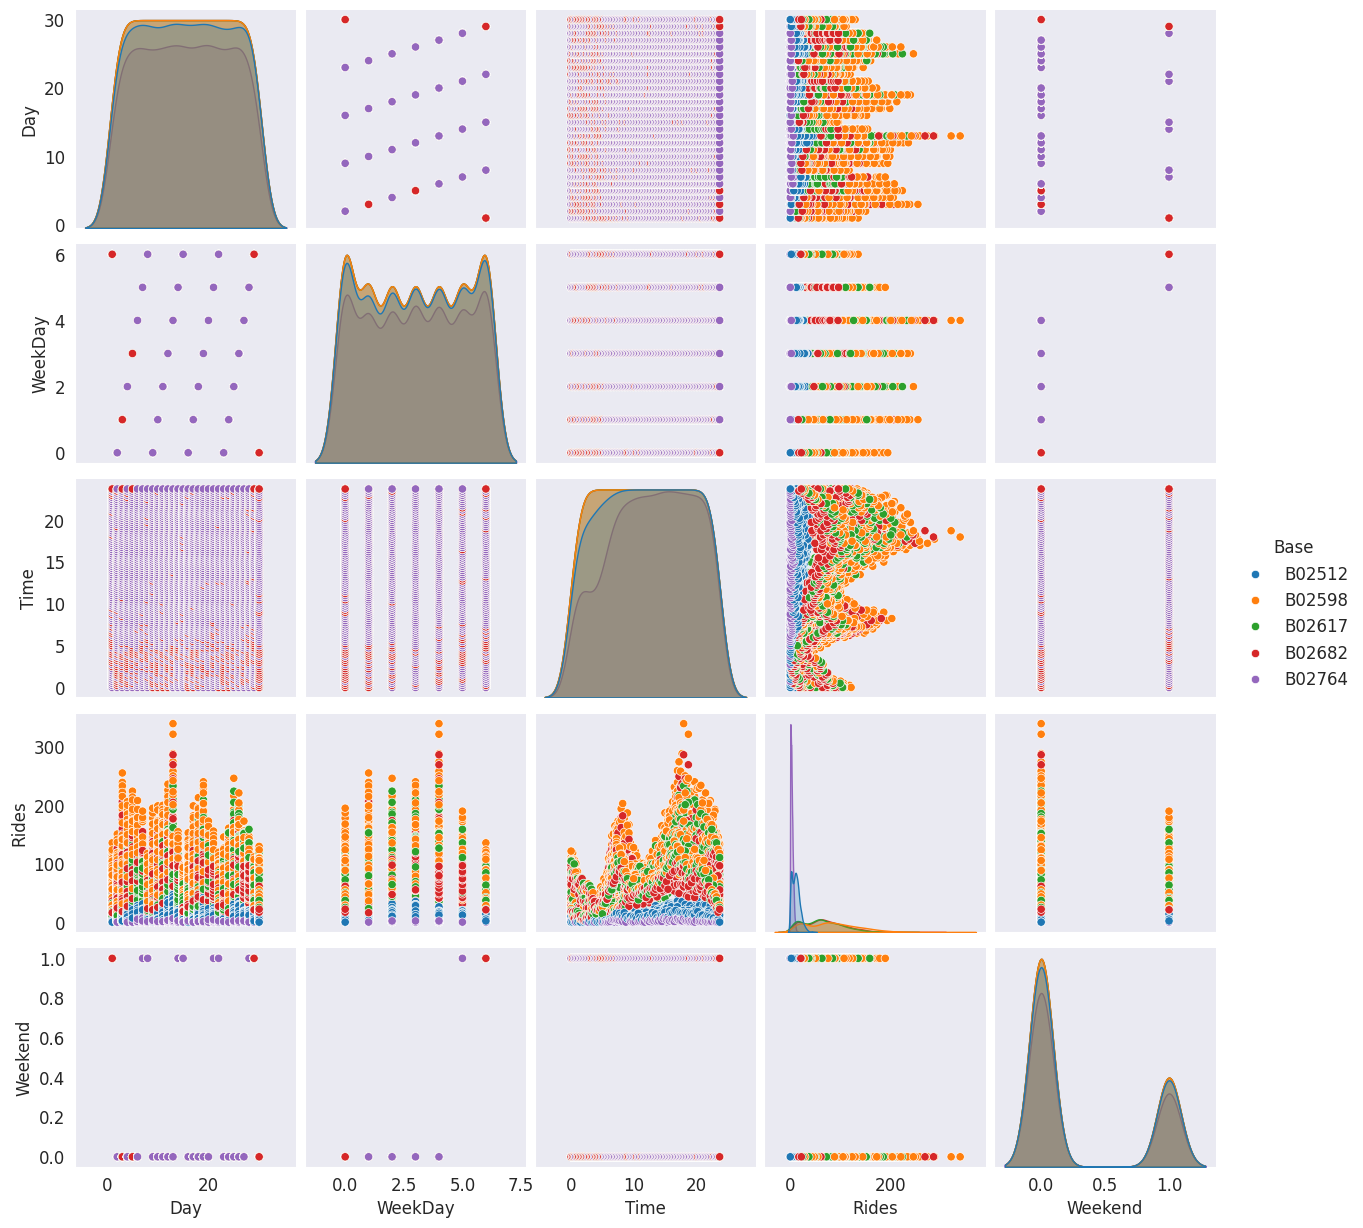

In [212]:
sns.pairplot(df,hue='Base')

**Notice the clusters in data! Especially time-rides, day-rides.**

**Let's create a jointplot of Rides vs Time**

<Figure size 640x480 with 0 Axes>

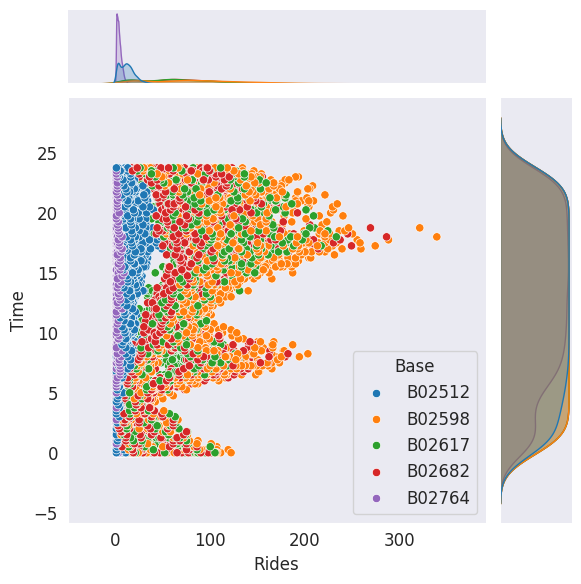

In [213]:
plt.figure()
_=sns.jointplot(x='Rides',y='Time',data = df,hue='Base')